In [1]:
# Library for export dataframe image 
# import dataframe_image as dfi

from random import randrange
from datetime import timedelta
from datetime import date
import numpy as np
import scipy.stats as stats
import pandas as pd
from datetime import timedelta
from matplotlib import pyplot as plt
import seaborn as sns

from pathlib import Path
import matplotlib.font_manager as font_manager

from sksurv.nonparametric import kaplan_meier_estimator


In [2]:
# Pandas settings
pd.set_option("display.max_column", None)
pd.set_option("display.max_colwidth", None)
pd.set_option('display.width', -1)
pd.set_option('display.max_rows', None)


# Font Path CONSTANTS
ROOT = Path('.')
POPPINS_FAMILY_PATH = ROOT.joinpath('fonts').joinpath('poppins')


font_dirs = [POPPINS_FAMILY_PATH]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

    
# Matplotlib Configurations

# Font Size
plt.rcParams['font.size'] = 14

# Text colors
plt.rcParams['text.color'] = '#2B3A55'
plt.rcParams['axes.labelcolor'] = '#2B3A55'
plt.rcParams['xtick.color'] = '#2B3A55'
plt.rcParams['ytick.color'] = '#2B3A55'

# Figure Colors
plt.rcParams['axes.facecolor']= '#E8C4C4'
plt.rcParams['savefig.facecolor']= '#E8C4C4'

# Border Color
plt.rcParams['axes.edgecolor'] = '#F2E5E5'

# Line Properties
plt.rcParams['lines.linewidth'] = 5

# Grid Properties
plt.rcParams['grid.alpha'] =  0.2
plt.rcParams['grid.color'] =  '#ffff'

In [3]:
# Fake date between two dates

def random_date(start_date: date, end_date: date) -> date:
    """
        Returns random date between two datetime
    """
    delta_day = (end_date - start_date).days
    random_day = randrange(delta_day)
    random_date = start_date + timedelta(days=random_day)
    return random_date

def top_up_date_generator(experiment_start: date, experiment_end: date, random_day: np.float64) -> tuple[date, date]:
    '''
        Generates artifically start and end date
    '''
    
    first_top_up_date = random_date(start_date, end_date)
    next_top_up_date = first_top_up_date + timedelta(random_day)    
    return (first_top_up_date, next_top_up_date)

In [4]:
top_up_dates = []

#Top-up Start and End Date
start_date = date(2022, 1, 1)
end_date = date(2022, 3, 31)


# Regular Consumers
for _ in range(7000):
    # large shape and scale parameters for regular consumers
    # I want to target 30-32 days for next-top-up dates for regular consumers
    random_day_from_weibull = stats.weibull_min.rvs(c=5, scale=32, loc=0)
    # Generate two top up dates
    first_top_up_date, next_top_up_date = top_up_date_generator(start_date, end_date, random_day_from_weibull)
    top_up_dates.append((first_top_up_date, next_top_up_date, 'regular'))
    
# Fast Consumers
for _ in range(2000):
    # Smaller shape and scale parameters for fast consumers
    # I want to target 26-28 days for next-top-up dates for fast consumers.
    random_day_from_weibull = stats.weibull_min.rvs(c=2, scale=28, loc=0)
    # Generate two top up dates
    first_top_up_date, next_top_up_date = top_up_date_generator(start_date, end_date, random_day_from_weibull)
    top_up_dates.append((first_top_up_date, next_top_up_date, 'fast'))
    
# Chunk Consumers
for _ in range(1000):
    # large shape and scale parameters for regular consumers
    # I want to target 90 days for next-top-up dates for regular consumers
    random_day_from_weibull = stats.weibull_min.rvs(c=20, scale=60, loc=0)
    # Generate two top up dates
    first_top_up_date, next_top_up_date = top_up_date_generator(start_date, end_date, random_day_from_weibull)
    top_up_dates.append((first_top_up_date, next_top_up_date, 'chunk'))

In [5]:
# Create Dataframe for artifically top-up-dates
df = pd.DataFrame(data=top_up_dates, columns=["first_top_up_date", "second_top_up_date", "segment"])

# Segment with rate of no_top_up consumers
# For example, 0.3 of regular segment consumers did not top up after first date
segments = [("regular", 0.3), ("fast", 0.2), ("chunk", 0.5)]

# Empty list for no_top_uppers index
no_top_uppers = []
for seg, no_top_up_rate in segments:
    segment_idx = df.loc[df["segment"] == seg].index
    no_top_up_idx = np.random.choice(segment_idx, size=int(len(segment_idx)*no_top_up_rate), replace=False)
    no_top_uppers.append(no_top_up_idx)
    
no_top_uppers = np.concatenate(no_top_uppers).ravel()

# Remove second top up dates 
df.loc[no_top_uppers, "second_top_up_date"] = np.nan

# If next-top-up date after experiment finish date, set null (Assume we don't know yet when we are at the end of the experiment)
df["second_top_up_date"] = np.where(df["second_top_up_date"] > end_date, np.nan, df["second_top_up_date"])

# Next top up day count Second - First
df["survival_in_days"] = np.where(df['second_top_up_date'].isnull(), 
        (end_date - df['first_top_up_date']).dt.days,
        (df['second_top_up_date'] - df['first_top_up_date']).dt.days
                                 )

# Sign 1 for top_up_customers 0 otherwise
df["status"] = ~df["second_top_up_date"].isnull()

# Shuffle dataset
df = df.sample(frac=1)

In [6]:
df.head(4)

,first_top_up_date,second_top_up_date,segment,survival_in_days,status
7322,2022-03-22,NaN,fast,9.0,False
3812,2022-02-26,NaN,regular,33.0,False
8327,2022-01-05,NaN,fast,85.0,False
6664,2022-01-25,2022-02-20,regular,26.0,True


In [7]:
print(df.groupby('segment').status.agg(['sum', 'count', 'mean']).to_markdown())

| segment   |   sum |   count |     mean |
|:----------|------:|--------:|---------:|
| chunk     |   187 |    1000 | 0.187    |
| fast      |  1164 |    2000 | 0.582    |
| regular   |  3397 |    7000 | 0.485286 |


In [8]:
df["survival_in_days"].mean()

30.224

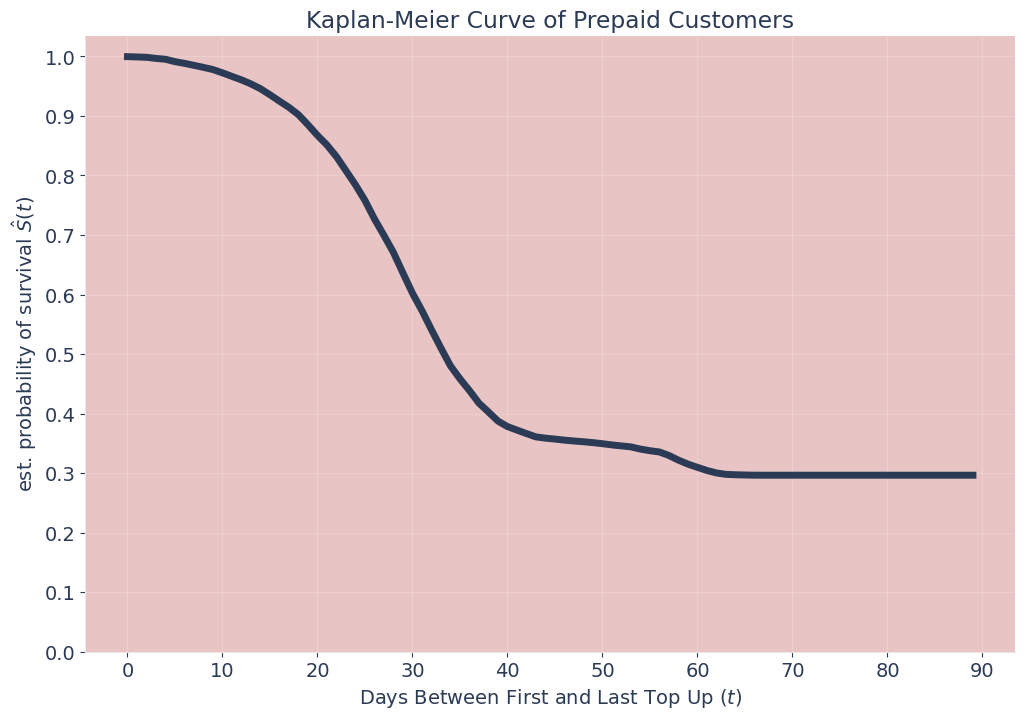

In [9]:
# Get Time and Survival Probabilities
time, survival_prob = kaplan_meier_estimator(df["status"], df["survival_in_days"])

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=None, x=time, y=survival_prob, color='#2B3A55', ax=ax)

# Plot Decoration
ax.set_title('Kaplan-Meier Curve of Prepaid Customers')
ax.set_ylabel("est. probability of survival $\hat{S}(t)$")
ax.set_xlabel("Days Between First and Last Top Up ($t$)")

# Remove Border
ax.spines[['top', 'right']].set_visible(False)

# Set ticks
ax.set_xticks(range(0, 91, 10))
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.grid()
# Save fig
plt.savefig('kaplan-meier-curve-all.png', dpi=150)
# Show fig
plt.show()

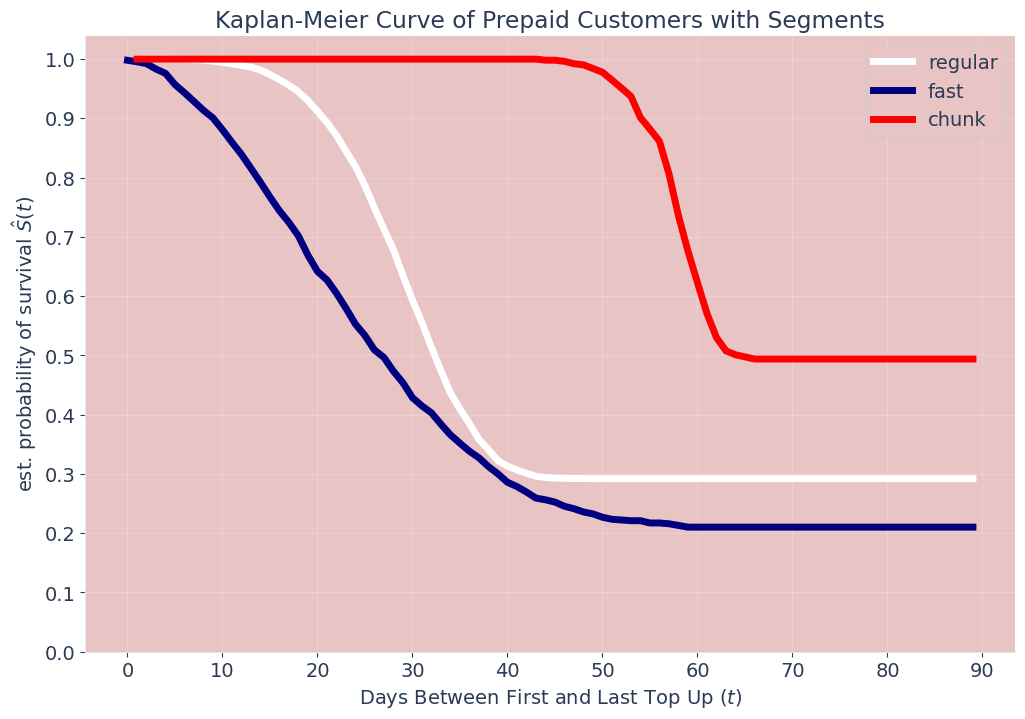

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

segments =  ("regular", "fast", "chunk")
colors = {
    "regular": "white",
    "fast": "navy",
    "chunk": "red"
}

for segment in segments:
    mask_segment = df["segment"] == segment
    time_segment, survival_prob_segment = kaplan_meier_estimator(
        df["status"][mask_segment],
        df["survival_in_days"][mask_segment])

    sns.lineplot(data=None, x=time_segment, y=survival_prob_segment, 
                 color=colors[segment], label=segment, ax=ax)

# Plot Decoration
ax.set_title('Kaplan-Meier Curve of Prepaid Customers with Segments')
ax.set_ylabel("est. probability of survival $\hat{S}(t)$")
ax.set_xlabel("Days Between First and Last Top Up ($t$)")

# Remove Border
ax.spines[['top', 'right']].set_visible(False)

# Set ticks
ax.set_xticks(range(0, 91, 10))
ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.legend()
plt.grid()
# Save fig
plt.savefig('kaplan-meier-curve-segmented.png', dpi=150)

# Show fig
plt.show()

In [12]:
df.to_csv('top-up-dates.csv')